# Digit Classification with KNN and Naive Bayes
By: Angela Gao (angelazgao@gmail.com)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import math

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Visualize some sample digits in a grid

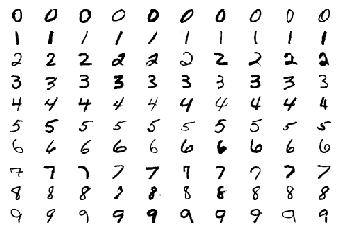

In [3]:
def plot_examples(num_examples=10):

    #ten samples of each digit type
    arr = []
    for i in range(10):
        arr.append(mini_train_data[mini_train_labels == str(i)][:num_examples])

    #set up subplots
    plt.rc('image',cmap='binary')
    fig, ax = plt.subplots(nrows=10, ncols = num_examples)

    #reshape feature vectors and render the matrices
    i = 0
    for row in arr:
        for col in row:
            a = col.reshape(-1,28)
            ax[i//10,i%10].imshow(a)
            ax[i//10,i%10].axis('off')
            i += 1
    plt.show()

plot_examples(10)

### K-Nearest Neighbors at various k-values

In [7]:
def run_knn(k_values):
    
    print("1-Nearest Neighbors Stats:")
    
    # performance of k-nearest neighbor at varying k 
    for k in k_values:
        mod = KNeighborsClassifier(k)
        mod.fit(mini_train_data, mini_train_labels)
        pred_labels = mod.predict(dev_data)
        
        # fit k=1 and get precision, recall, and F1
        if k == 1:
            print(classification_report(dev_labels, pred_labels))
            
        print('k=%d: Misclassified Cnt' % k, sum(pred_labels != dev_labels))

k_values = [1, 3, 5, 7, 9]
run_knn(k_values)

1-Nearest Neighbors Stats:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

k=1: Misclassified Cnt 116
k=3: Misclassified Cnt 124
k=5: Misclassified Cnt 118
k=7: Misclassified Cnt 123
k=9: Misclassified Cnt 125


### 1-Nearest Neighbors at various training sizes

In [8]:
def run_1nn_t(train_sizes, accuracies):

    # using four different training data sizes
    for t in train_sizes:
        t_data = train_data[:t]
        t_labels = train_labels[:t]
    
        #model start time
        start = time.time()
    
        #model fit and eval
        mod = KNeighborsClassifier(1)
        mod.fit(t_data, t_labels)
        pred_labels = mod.predict(dev_data)
    
        #model run time
        end = time.time()
        elapse = end - start
        
        print('Training data size %d: Misclassified =' % t, sum(pred_labels != dev_labels), '| Time =', elapse)
        accuracies.append(classification_report(dev_labels, pred_labels).replace(" ","")[-62:-58])

    print('Accuracies =', [float(i) for i in accuracies])

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
run_1nn_t(train_sizes, accuracies)

Training data size 100: Misclassified = 298 | Time = 0.13794827461242676
Training data size 200: Misclassified = 209 | Time = 0.23318195343017578
Training data size 400: Misclassified = 189 | Time = 0.4753689765930176
Training data size 800: Misclassified = 134 | Time = 1.0407938957214355
Training data size 1600: Misclassified = 95 | Time = 1.9597280025482178
Training data size 3200: Misclassified = 73 | Time = 4.5572569370269775
Training data size 6400: Misclassified = 61 | Time = 7.529912948608398
Training data size 12800: Misclassified = 48 | Time = 15.754199743270874
Training data size 25600: Misclassified = 37 | Time = 34.2971670627594
Accuracies = [0.7, 0.79, 0.81, 0.87, 0.91, 0.93, 0.94, 0.95, 0.96]


### 1-Nearest Neighbors confusion matrix + missclassified examples

In [9]:
def cc_miss():

    #model fit and eval
    mod = KNeighborsClassifier(1)
    mod.fit(mini_train_data, mini_train_labels)
    pred_labels = mod.predict(dev_data)
    
    #confusion matrix
    conf = confusion_matrix(dev_labels, pred_labels)
    print(conf)
    
    #after looking at confusion_matrix output
    
    #digit pairs with the greatest number of mistakes (4 <-> 9)
    fig, ax = plt.subplots(11)
    most = dev_data[np.logical_and(dev_labels == '4', pred_labels == '9')]
    for i in range(len(most)):
        a = most[i].reshape(-1,28)
        ax[i].imshow(a)
        ax[i].axis('off')

cc_miss()

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


### Applying a Gaussian blur

In [10]:
#function to filter matrix and return filtered feature vector
def blur_filter(img):
    
    output = np.zeros(img.shape)
    
    #grab surrounding 9 pixels 
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            surround = img[i-1:i+2, j-1:j+2]
            
            #take the average and insert into output
            s = surround.flatten() / 9 
            output[i,j] = s.sum()
    
    #return filtered feature vector 
    return output.flatten()

In [11]:
def with_blur():
    
    mini_train_filter = []
    dev_data_filter = []
    
    #use blur_filter on training and dev data
    for i in range(1000):
        mini_train_filter.append(blur_filter(mini_train_data[i].reshape(-1,28)))
        dev_data_filter.append(blur_filter(dev_data[i].reshape(-1,28)))
    
    ######## filter training only classifier
    mod1 = KNeighborsClassifier(1)
    mod1.fit(mini_train_filter, mini_train_labels)
    pred1 = mod1.predict(dev_data)
    
    ######## filter dev only classifier
    mod2 = KNeighborsClassifier(1)
    mod2.fit(mini_train_data, mini_train_labels)
    pred2 = mod2.predict(dev_data_filter)
    
    ######## filter training and dev classifier
    mod3 = KNeighborsClassifier(1)
    mod3.fit(mini_train_filter, mini_train_labels)
    pred3 = mod1.predict(dev_data_filter)
    
    print('Filtered training set: Misclassified =', sum(pred1 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred1).replace(" ","")[-62:-58])
    print('Filtered dev data set: Misclassified =', sum(pred2 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred2).replace(" ","")[-62:-58])
    print('Filtered training & dev: Misclassified =', sum(pred3 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred3).replace(" ","")[-62:-58])


with_blur()

Filtered training set: Misclassified = 93 | Accuracy = 0.91
Filtered dev data set: Misclassified = 132 | Accuracy = 0.87
Filtered training & dev: Misclassified = 95 | Accuracy = 0.91


***
### Bernoulli and Multimodal Naive Bayes

In [12]:
def ber_multi():

    #binary model 
    mod1 = BernoulliNB(binarize = 0.3)
    mod1.fit(mini_train_data, mini_train_labels)
    pred1 = mod1.predict(dev_data)
    
    #pre-process training data to three categories
    mini_train_multi = []
    for i in range(1000):
        multi_nom = []
        for x in mini_train_data[i]:
            if x <= 0.3:
                multi_nom.append(0)
            elif x >= 0.8:
                multi_nom.append(2)
            else:
                multi_nom.append(1)
        mini_train_multi.append(multi_nom)
    
    #multinomial model
    mod2 = MultinomialNB()
    mod2.fit(mini_train_data, mini_train_labels)
    pred2 = mod2.predict(dev_data)
    
    print('Bernoulli: Misclassified =', sum(pred1 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred1).replace(" ","")[-62:-58])
    print('Multinomial: Misclassified =', sum(pred2 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred2).replace(" ","")[-62:-58])

ber_multi()

Bernoulli: Misclassified = 173 | Accuracy = 0.83
Multinomial: Misclassified = 193 | Accuracy = 0.81


### Vary Bernoulli LaPlace smoothing parameter

In [13]:
def laplace(alphas):
    
    #evaluate performance of various alpha values
    mod = BernoulliNB()
    clf = GridSearchCV(mod, alphas)
    return clf.fit(mini_train_data, mini_train_labels)
    
#print accuracy levels later on
    
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = laplace(alphas)
print('Accuracy: ', nb.cv_results_['mean_test_score'])
print("Best alpha = ", nb.best_params_)

Accuracy:  [0.814 0.819 0.825 0.822 0.818 0.813 0.809 0.805 0.783]
Best alpha =  {'alpha': 0.001}


### Gaussian Naive Bayes

In [15]:
def gaussian():

    #initial no adjustment gaussian
    mod1 = GaussianNB()
    mod1.fit(mini_train_data, mini_train_labels)
    pred1 = mod1.predict(dev_data)
    print('Gaussian Initial: Misclassified =', sum(pred1 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred1).replace(" ","")[-62:-58])
    
    #smoothed var adjusted gaussian
    mod2 = GaussianNB(var_smoothing = 0.05)
    mod2.fit(mini_train_data, mini_train_labels)
    pred2 = mod2.predict(dev_data)
    print('Gaussian Smoothed: Misclassified =', sum(pred2 != dev_labels), '| Accuracy =', classification_report(dev_labels, pred2).replace(" ","")[-62:-58])

gaussian()

Gaussian Initial: Misclassified = 407 | Accuracy = 0.59
Gaussian Smoothed: Misclassified = 184 | Accuracy = 0.82


### Using NB as generative model

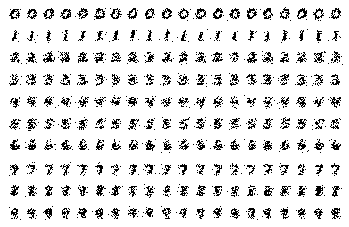

In [16]:
def generate(num_examples):

    #set up subplots
    plt.rc('image',cmap='binary')
    fig, ax = plt.subplots(nrows=10, ncols = num_examples)

    #bernoulli generative model for the probabilities
    mod = BernoulliNB()
    mod.fit(mini_train_data, mini_train_labels)
    log_prob = mod.feature_log_prob_
    
    #compare random numbers with probabilities for binary features
    for i in range(10):
        pb = [np.exp(i) for i in log_prob[i]]
        for j in range(num_examples):
            rd = np.random.rand(784)
            gen = []
            for r,p in zip(rd, pb):
                if r < p:
                    gen.append(1)
                else:
                    gen.append(0)
                    
            #reshape and render the feature vectors
            g = np.array(gen).reshape(-1,28)
            ax[i,j].imshow(g)
            ax[i,j].axis('off')
                
    plt.show()

generate(20)

### Evaluate Bernoulli NB Calibration

In [17]:
def calibrate(buckets, correct, total):
    
    #use bernoullinb to find maximum posterior probabilities 
    mod = BernoulliNB(alpha = 0.001)
    mod.fit(mini_train_data, mini_train_labels)
    post = [[i.max(), i.argmax(axis=0)] for i in mod.predict_proba(dev_data)]
    
    #partition into buckets 
    for i in range(1000): 
        index = [buckets.index(b) for b in buckets if b < post[i][0]]
        
        #update total and correct counters
        total[index[-1]+1] += 1
        if int(dev_labels[i]) == post[i][1]:
            correct[index[-1]+1] += 1
                


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

calibrate(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

p(pred) is 0.0000000000000 to 0.5000000000000    total =   0    accuracy = 0.000
p(pred) is 0.5000000000000 to 0.9000000000000    total =  31    accuracy = 0.355
p(pred) is 0.9000000000000 to 0.9990000000000    total =  67    accuracy = 0.433
p(pred) is 0.9990000000000 to 0.9999900000000    total =  59    accuracy = 0.458
p(pred) is 0.9999900000000 to 0.9999999000000    total =  46    accuracy = 0.652
p(pred) is 0.9999999000000 to 0.9999999990000    total =  62    accuracy = 0.774
p(pred) is 0.9999999990000 to 0.9999999999900    total =  33    accuracy = 0.788
p(pred) is 0.9999999999900 to 0.9999999999999    total =  43    accuracy = 0.791
p(pred) is 0.9999999999999 to 1.0000000000000    total = 659    accuracy = 0.938
